In [2]:
import networkx as nx
import matplotlib as plt
import numpy as np
import time
from qiskit_optimization.applications import Maxcut
from qiskit.visualization import array_to_latex
from qiskit.circuit.library import TwoLocal
from qiskit_algorithms.minimum_eigensolvers import SamplingVQE,VQE,SamplingMinimumEigensolver
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit_algorithms.optimizers import SPSA
from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector, random_statevector
from qiskit.quantum_info.operators import Operator, Pauli
from qiskit.primitives import Sampler,Estimator

<h1>Basic WorkFlow</h1>
<ol>
1. Construct the Graph<br>
2. Construct the $Q$ matrix from the weight matrix.<br>
3. We will be converting it into a MaxCut problem. Use the <code>Maxcut</code> function from <code>qiskit_optimization.applications</code> library to create a quadratic program. <br>
4. Map the quadratic program as Ising problem; N qubits for N variables <br>
5. Solving using VQE :<br>
    a. Generate an ansatz circuit (choose the entangled strategy as <i>linear</i> (it depends))<br>
    b. Select an optimizer<br>
    c. Run the VQE Algorithm as:<br>
        <code>vqe = SamplingVQE(sampler=Sampler(),ansatz,optimiser)</code><br>
        <code>vqe_1 = MinimumEigenOptimizer(vqe)</code><br>
    d. Get the result as <code>vqe_1.solve(quadratic program)</code><br>

How VQE works:<br>
Finds the minimum eigenvalue of a Hamiltonian<br>
QUBO problems are turned into Ising problems which are solved using VQE<br>
It is a hybrid algorithm (classical & quantum)
    1. Fix a guess of parameters. (Classical)<br>
    2. Generate a parameterised circuit (which represents a wave function/quantum state) (Quantum)<br>
    3. Find its Minimum Eigenvalue (Quantum)<br>
    4. Change the parameter and repeat till minimum found.(Classical)<br>

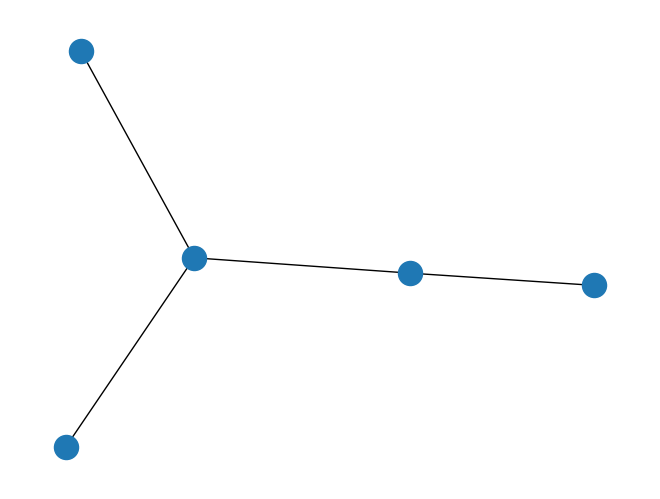

In [24]:
G = nx.Graph()
G.add_nodes_from(range(5))

edges = [(0,3,1),(1,2,1),(3,4,1),(2,3,1)]
G.add_weighted_edges_from(edges)
nx.draw(G)

In [4]:
wMat = np.zeros([5,5])

In [5]:
for i in range(5):
    for j in range(5):
        wMat[i,j] = 1 if((i,j,1) in edges) else 0

In [6]:
wMat

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0.]])

In [7]:
max_cut = Maxcut(wMat)

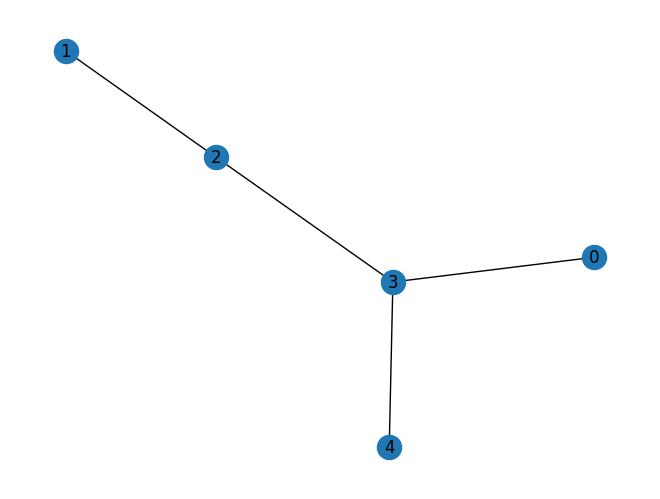

In [10]:
max_cut.draw()

In [54]:
program = max_cut.to_quadratic_program()
print(program.prettyprint())

Problem name: Max-cut

Maximize
  -2*x_0*x_3 - 2*x_1*x_2 - 2*x_2*x_3 - 2*x_3*x_4 + x_0 + x_1 + 2*x_2 + 3*x_3
  + x_4

Subject to
  No constraints

  Binary variables (5)
    x_0 x_1 x_2 x_3 x_4



In [55]:
qubitOp,offset = program.to_ising()

In [62]:
array_to_latex(qubitOp.to_matrix())

<IPython.core.display.Latex object>

In [27]:
two = TwoLocal(3,'rx','cx','linear',reps=2,insert_barriers=True)

In [31]:
(two.decompose()).draw()

┌──────────┐ ░            ░ ┌──────────┐ ░            ░ ┌──────────┐
q_0: ┤ Rx(θ[0]) ├─░───■────────░─┤ Rx(θ[3]) ├─░───■────────░─┤ Rx(θ[6]) ├
     ├──────────┤ ░ ┌─┴─┐      ░ ├──────────┤ ░ ┌─┴─┐      ░ ├──────────┤
q_1: ┤ Rx(θ[1]) ├─░─┤ X ├──■───░─┤ Rx(θ[4]) ├─░─┤ X ├──■───░─┤ Rx(θ[7]) ├
     ├──────────┤ ░ └───┘┌─┴─┐ ░ ├──────────┤ ░ └───┘┌─┴─┐ ░ ├──────────┤
q_2: ┤ Rx(θ[2]) ├─░──────┤ X ├─░─┤ Rx(θ[5]) ├─░──────┤ X ├─░─┤ Rx(θ[8]) ├
     └──────────┘ ░      └───┘ ░ └──────────┘ ░      └───┘ ░ └──────────┘

In [117]:
t1 = time.ctime().split()[3] # 35 s
two = TwoLocal(5,'rx','cx','linear',reps=2,insert_barriers=True)
optimizer = SPSA(maxiter=3000)
vqe = SamplingVQE(sampler=Sampler(),ansatz=two,optimizer=optimizer)
vqe_op1 = MinimumEigenOptimizer(vqe)
result = vqe_op1.solve(program)
t2 = time.ctime().split()[3]
print(t2,t1)
print(result.prettyprint())


17:43:25 17:42:50
objective function value: 4.0
variable values: x_0=0.0, x_1=1.0, x_2=0.0, x_3=1.0, x_4=0.0
status: SUCCESS


In [118]:
t1 = time.ctime().split()[3] # 43 s
two = TwoLocal(5,'rx','cx','full',reps=2,insert_barriers=True)
optimizer = SPSA(maxiter=3000)
vqe = SamplingVQE(sampler=Sampler(),ansatz=two,optimizer=optimizer)
vqe_op1 = MinimumEigenOptimizer(vqe)
result = vqe_op1.solve(program)
t2 = time.ctime().split()[3]
print(t2,t1)
print(result.prettyprint())

17:44:27 17:43:44
objective function value: 4.0
variable values: x_0=0.0, x_1=1.0, x_2=0.0, x_3=1.0, x_4=0.0
status: SUCCESS


In [119]:
t1 = time.ctime().split()[3] # 36 s
two = TwoLocal(5,'rx','cx','reverse_linear',reps=2,insert_barriers=True)
optimizer = SPSA(maxiter=3000)
vqe = SamplingVQE(sampler=Sampler(),ansatz=two,optimizer=optimizer)
vqe_op1 = MinimumEigenOptimizer(vqe)
result = vqe_op1.solve(program)
t2 = time.ctime().split()[3]
print(t2,t1)
print(result.prettyprint())

17:45:17 17:44:41
objective function value: 4.0
variable values: x_0=0.0, x_1=1.0, x_2=0.0, x_3=1.0, x_4=0.0
status: SUCCESS


In [120]:
t1 = time.ctime().split()[3] # 34 s
two = TwoLocal(5,'rx','cx','pairwise',reps=2,insert_barriers=True)
optimizer = SPSA(maxiter=3000)
vqe = SamplingVQE(sampler=Sampler(),ansatz=two,optimizer=optimizer)
vqe_op1 = MinimumEigenOptimizer(vqe)
result = vqe_op1.solve(program)
t2 = time.ctime().split()[3]
print(t2,t1)
print(result.prettyprint())

17:45:51 17:45:17
objective function value: 4.0
variable values: x_0=1.0, x_1=0.0, x_2=1.0, x_3=0.0, x_4=1.0
status: SUCCESS


In [121]:
t1 = time.ctime().split()[3] # 36 s
two = TwoLocal(5,'rx','cx','circular',reps=2,insert_barriers=True)
optimizer = SPSA(maxiter=3000)
vqe = SamplingVQE(sampler=Sampler(),ansatz=two,optimizer=optimizer)
vqe_op1 = MinimumEigenOptimizer(vqe)
result = vqe_op1.solve(program)
t2 = time.ctime().split()[3]
print(t2,t1)
print(result.prettyprint())

17:46:27 17:45:51
objective function value: 4.0
variable values: x_0=0.0, x_1=1.0, x_2=0.0, x_3=1.0, x_4=0.0
status: SUCCESS


In [122]:
t1 = time.ctime().split()[3] # 38 s
two = TwoLocal(5,'rx','cx','sca',reps=2,insert_barriers=True)
optimizer = SPSA(maxiter=3000)
vqe = SamplingVQE(sampler=Sampler(),ansatz=two,optimizer=optimizer)
vqe_op1 = MinimumEigenOptimizer(vqe)
result = vqe_op1.solve(program)
t2 = time.ctime().split()[3]
print(t2,t1)
print(result.prettyprint())

17:47:05 17:46:27
objective function value: 4.0
variable values: x_0=0.0, x_1=1.0, x_2=0.0, x_3=1.0, x_4=0.0
status: SUCCESS


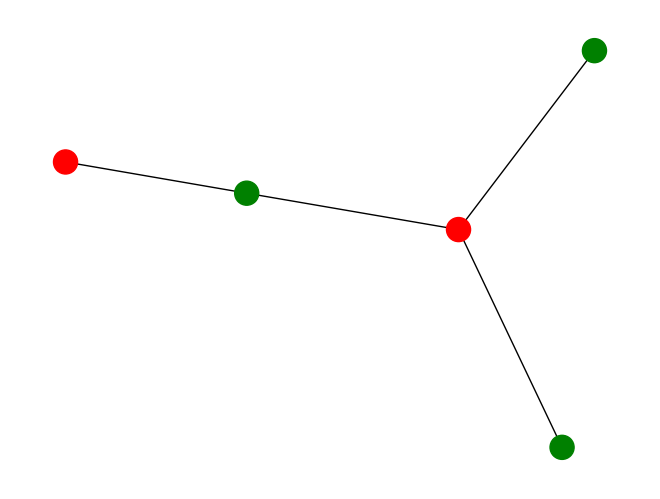

In [128]:
colors = ["g" if result.x[i] == 0 else "r" for i in range(5)]
nx.draw(G, node_color=colors)